In [ ]:
!pip install pennylane torch torchvision torchaudio


In [ ]:
!pip install -q isic-cli
!isic user login


Hello solari93por21@gmail.com!


In [ ]:
#This code was built by muhannad alkwiefati
# 1) Install isic-cli
# ===============================
!pip install -q isic-cli

# ===============================
# 2) Login
# ===============================
!isic user login

# ===============================
# 3) Download Challenge 2019 Training (Collection 65)
# ===============================
!mkdir -p data2019/all/healthy data2019/all/malignant
!isic image download --collections 65 --search 'diagnosis_1:"Benign"'    --limit 2000 data2019/all/healthy
!isic image download --collections 65 --search 'diagnosis_1:"Malignant"' --limit 2000 data2019/all/malignant


Hello solari93por21@gmail.com!

Successfully downloaded 2,000 images to data2019/all/healthy/.
Successfully wrote 2,000 metadata records to data2019/all/healthy/metadata.csv.
Successfully wrote attributions to data2019/all/healthy/attribution.txt.
Successfully wrote 1 license(s) to data2019/all/healthy/licenses.

Successfully downloaded 2,000 images to data2019/all/malignant/.
Successfully wrote 2,000 metadata records to data2019/all/malignant/metadata.csv.
Successfully wrote attributions to data2019/all/malignant/attribution.txt.
Successfully wrote 2 license(s) to data2019/all/malignant/licenses.


 Deleted 0 duplicate images
Balancing dataset → 2000 per class
healthy: 1600 train, 200 val, 200 test
malignant: 1600 train, 200 val, 200 test
train/healthy : 1600
train/malignant : 1600
val/healthy : 200
val/malignant : 200
test/healthy : 200
test/malignant : 200


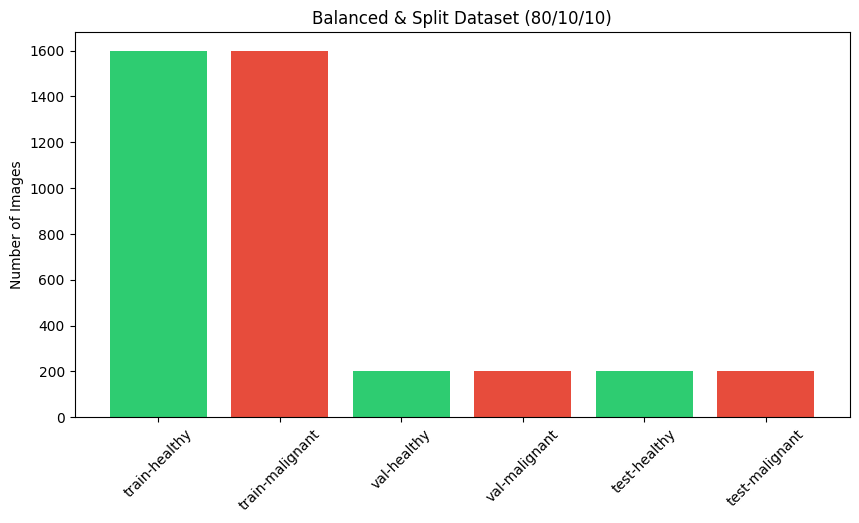

In [ ]:
import pathlib, hashlib, os, random, shutil, matplotlib.pyplot as plt
random.seed(42)

base = pathlib.Path("data2019")

# =============== 1) Remove duplicates ===============
def file_hash(path, algo="md5", chunk_size=8192):
    h = hashlib.new(algo)
    with open(path, "rb") as f:
        while chunk := f.read(chunk_size):
            h.update(chunk)
    return h.hexdigest()

def remove_duplicates(root="data2019/all"):
    root = pathlib.Path(root)
    hashes, deleted = {}, 0
    for img_path in root.rglob("*.jpg"):
        h = file_hash(img_path)
        if h in hashes:
            os.remove(img_path)
            deleted += 1
        else:
            hashes[h] = img_path
    print(f" Deleted {deleted} duplicate images")

remove_duplicates()

#2) Balance dataset before splitting
def balance_classes():
    h_imgs = list((base/"all"/"healthy").glob("*.jpg"))
    m_imgs = list((base/"all"/"malignant").glob("*.jpg"))

    target = min(len(h_imgs), len(m_imgs))  # equalize to smaller class
    print(f"Balancing dataset → {target} per class")

    for cls, imgs in [("healthy", h_imgs), ("malignant", m_imgs)]:
        if len(imgs) > target:
            to_remove = random.sample(imgs, len(imgs)-target)
            for f in to_remove: os.remove(f)

balance_classes()

#3) Clean old splits
for split in ["train","val","test"]:
    for cls in ["healthy","malignant"]:
        folder = base/split/cls
        if folder.exists():
            shutil.rmtree(folder)

# =============== 4) Split 80/10/10 ===============
def split_dataset(cls, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    all_imgs = list((base/"all"/cls).glob("*.jpg"))
    random.shuffle(all_imgs)

    n_total = len(all_imgs)
    n_train = int(n_total * train_ratio)
    n_val   = int(n_total * val_ratio)
    n_test  = n_total - n_train - n_val

    splits = {
        "train": all_imgs[:n_train],
        "val"  : all_imgs[n_train:n_train+n_val],
        "test" : all_imgs[n_train+n_val:]
    }

    for split, imgs in splits.items():
        outdir = base/split/cls
        outdir.mkdir(parents=True, exist_ok=True)
        for img in imgs:
            shutil.copy(str(img), str(outdir/img.name))

    print(f"{cls}: {n_train} train, {n_val} val, {n_test} test")

split_dataset("healthy")
split_dataset("malignant")

# =============== 5) Show final counts + plot ===============
counts = {}
for split in ["train","val","test"]:
    counts[split] = {}
    for cls in ["healthy","malignant"]:
        folder = base/split/cls
        count = len(list(folder.glob("*.jpg")))
        counts[split][cls] = count
        print(f"{split}/{cls} : {count}")

labels, values = [], []
for split in counts:
    for cls in counts[split]:
        labels.append(f"{split}-{cls}")
        values.append(counts[split][cls])

plt.figure(figsize=(10,5))
plt.bar(labels, values, color=["#2ecc71","#e74c3c"]*3)
plt.title("Balanced & Split Dataset (80/10/10)")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets.folder import default_loader
import pathlib
from collections import Counter

# Simple dataset class
class SimpleImageDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform
        self.loader = default_loader
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        path, y = self.samples[idx]
        img = self.loader(path)
        if self.transform:
            img = self.transform(img)
        return img, y

def make_loaders(base="data2019", image_size=32, batch_size=32, seed=42):
    base = pathlib.Path(base)
    #   [-1,1]ImageNet
    mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]

    # Train transforms with augmentations
    tf_train = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Eval transforms (val/test)
    tf_eval = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Helper to gather samples
    def gather(split, cls, label):
        folder = base/f"{split}/{cls}"
        return [(str(p), label) for p in folder.glob("*.jpg")]

    # Gather all samples
    samples_train = gather("train","healthy",0) + gather("train","malignant",1)
    samples_val   = gather("val","healthy",0)   + gather("val","malignant",1)
    samples_test  = gather("test","healthy",0)  + gather("test","malignant",1)

    # Datasets
    ds_train = SimpleImageDataset(samples_train, transform=tf_train)
    ds_val   = SimpleImageDataset(samples_val, transform=tf_eval)
    ds_test  = SimpleImageDataset(samples_test, transform=tf_eval)

    # DataLoaders
    train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # Info
    print("DataLoaders ready.")
    print("Train samples:", len(ds_train), "| Val:", len(ds_val), "| Test:", len(ds_test))
    print("Class dist (train):", Counter([y for _,y in ds_train.samples]))

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = make_loaders(image_size=32, batch_size=32)


DataLoaders ready.
Train samples: 3200 | Val: 400 | Test: 400
Class dist (train): Counter({0: 1600, 1: 1600})


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import pennylane as qml

# Quantum settings
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class HQCNNLayer(nn.Module):
    def __init__(self, in_features, n_qubits=4, n_layers=2):
        super().__init__()
        self.n_qubits = n_qubits
        self.weight_shapes = {"weights": (n_layers, n_qubits)}
        self.q_layer = qml.qnn.TorchLayer(quantum_circuit, self.weight_shapes)
        self.fc = nn.Linear(in_features, n_qubits)
    def forward(self, x):
        x = self.fc(x)
        return self.q_layer(x)


In [ ]:
class MobileNetBackbone(nn.Module):
    def __init__(self, pretrained=True):
        super(MobileNetBackbone, self).__init__()
        mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1 if pretrained else None)
        self.features = mobilenet.features
        self.out_channels = 1280
    def forward(self, x):
        return self.features(x)


In [ ]:
class HybridSkinCancerNet(nn.Module):
    def __init__(self, num_classes=2, hidden_size=256, num_layers=1):
        super(HybridSkinCancerNet, self).__init__()
        # 1. Backbone CNN
        self.backbone = MobileNetBackbone(pretrained=True)

        # 2. BiLSTM
        self.lstm = nn.LSTM(
            input_size=self.backbone.out_channels,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        # 3. Fully Connected before Quantum
        self.fc1 = nn.Linear(hidden_size*2, 64)
        self.dropout = nn.Dropout(0.3)

        # 4. HQCNN Quantum Layer
        self.hqcnn = HQCNNLayer(64, n_qubits=4, n_layers=2)

        # 5. Output
        self.fc_out = nn.Linear(4, num_classes)

    def forward(self, x):
        # Backbone CNN
        x = self.backbone(x)
        x = F.adaptive_avg_pool2d(x, (1,1))  # [B, 1280, 1, 1]
        x = x.view(x.size(0), 1, -1)         # [B, 1, 1280]

        # BiLSTM
        lstm_out, _ = self.lstm(x)           # [B, 1, hidden*2]
        x = lstm_out[:, -1, :]               # [B, hidden*2]

        # FC + Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Quantum layer
        x = self.hqcnn(x)

        # Output
        x = self.fc_out(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridSkinCancerNet(num_classes=2).to(device)
print(model)

HybridSkinCancerNet(
  (backbone): MobileNetBackbone(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96,

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class HybridSkinCancerNet(nn.Module):
    def __init__(self, num_classes=2):
        super(HybridSkinCancerNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*64*64, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



Epoch 1/30


Train: loss=0.6611, acc=0.5000
Val:   loss=0.6233, acc=0.5000
Saved best model

Epoch 2/30


Train: loss=0.5992, acc=0.5716
Val:   loss=0.5693, acc=0.7875
Saved best model

Epoch 3/30


Train: loss=0.5799, acc=0.7466
Val:   loss=0.5411, acc=0.8175
Saved best model

Epoch 4/30


Train: loss=0.5639, acc=0.7919
Val:   loss=0.5586, acc=0.7975
 EarlyStopping counter: 1/5

Epoch 5/30


Train: loss=0.5535, acc=0.8034
Val:   loss=0.5565, acc=0.8025
 EarlyStopping counter: 2/5

Epoch 6/30


Train: loss=0.5400, acc=0.8137
Val:   loss=0.5071, acc=0.8625
Saved best model

Epoch 7/30


Train: loss=0.5305, acc=0.8200
Val:   loss=0.5181, acc=0.8225
 EarlyStopping counter: 1/5

Epoch 8/30


Train: loss=0.5175, acc=0.8241
Val:   loss=0.5032, acc=0.8275
Saved best model

Epoch 9/30


Train: loss=0.5096, acc=0.8287
Val:   loss=0.5221, acc=0.7850
 EarlyStopping counter: 1/5

Epoch 10/30


Train: loss=0.5061, acc=0.8231
Val:   loss=0.4802, acc=0.8450
Saved best model

Epoch 11/30


Train: loss=0.4954, acc=0.8306
Val:   loss=0.5077, acc=0.8100
 EarlyStopping counter: 1/5

Epoch 12/30


Train: loss=0.4840, acc=0.8353
Val:   loss=0.4499, acc=0.8500
Saved best model

Epoch 13/30


Train: loss=0.4793, acc=0.8325
Val:   loss=0.4440, acc=0.8650
Saved best model

Epoch 14/30


Train: loss=0.4693, acc=0.8384
Val:   loss=0.4571, acc=0.8450
 EarlyStopping counter: 1/5

Epoch 15/30


Train: loss=0.4624, acc=0.8450
Val:   loss=0.4283, acc=0.8700
Saved best model

Epoch 16/30


Train: loss=0.4483, acc=0.8550
Val:   loss=0.4139, acc=0.8675
Saved best model

Epoch 17/30


Train: loss=0.4467, acc=0.8466
Val:   loss=0.4168, acc=0.8725
 EarlyStopping counter: 1/5

Epoch 18/30


Train: loss=0.4400, acc=0.8466
Val:   loss=0.4171, acc=0.8600
 EarlyStopping counter: 2/5

Epoch 19/30


Train: loss=0.4322, acc=0.8528
Val:   loss=0.4158, acc=0.8575
 EarlyStopping counter: 3/5

Epoch 20/30


Train: loss=0.4246, acc=0.8588
Val:   loss=0.4026, acc=0.8650
Saved best model

Epoch 21/30


Train: loss=0.4197, acc=0.8569
Val:   loss=0.3847, acc=0.8750
Saved best model

Epoch 22/30


Train: loss=0.4066, acc=0.8669
Val:   loss=0.3871, acc=0.8725
 EarlyStopping counter: 1/5

Epoch 23/30


Train: loss=0.4146, acc=0.8534
Val:   loss=0.3986, acc=0.8625
 EarlyStopping counter: 2/5

Epoch 24/30


Train: loss=0.4027, acc=0.8616
Val:   loss=0.3867, acc=0.8650
 EarlyStopping counter: 3/5

Epoch 25/30


Train: loss=0.4004, acc=0.8588
Val:   loss=0.3741, acc=0.8850
Saved best model

Epoch 26/30


Train: loss=0.3912, acc=0.8684
Val:   loss=0.3758, acc=0.8850
 EarlyStopping counter: 1/5

Epoch 27/30


Train: loss=0.3897, acc=0.8616
Val:   loss=0.3614, acc=0.8725
Saved best model

Epoch 28/30


Train: loss=0.3748, acc=0.8753
Val:   loss=0.3767, acc=0.8600
 EarlyStopping counter: 1/5

Epoch 29/30


Train: loss=0.3683, acc=0.8769
Val:   loss=0.3512, acc=0.8850
Saved best model

Epoch 30/30


Train: loss=0.3613, acc=0.8803
Val:   loss=0.3424, acc=0.8875
Saved best model



=== Test Results ===
Loss=0.3627, Acc=0.8700

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.87      0.88      0.87       200
   Malignant       0.87      0.86      0.87       200

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400


Confusion Matrix:
 [[175  25]
 [ 27 173]]


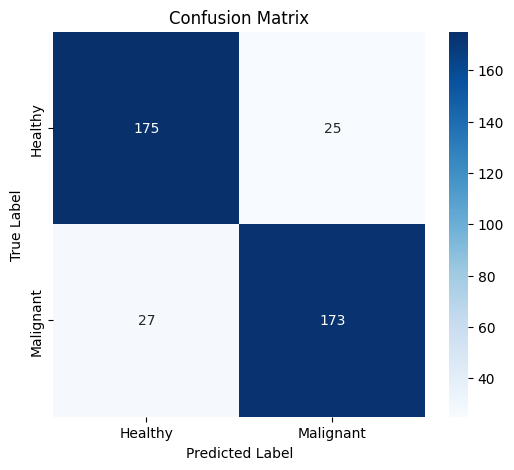

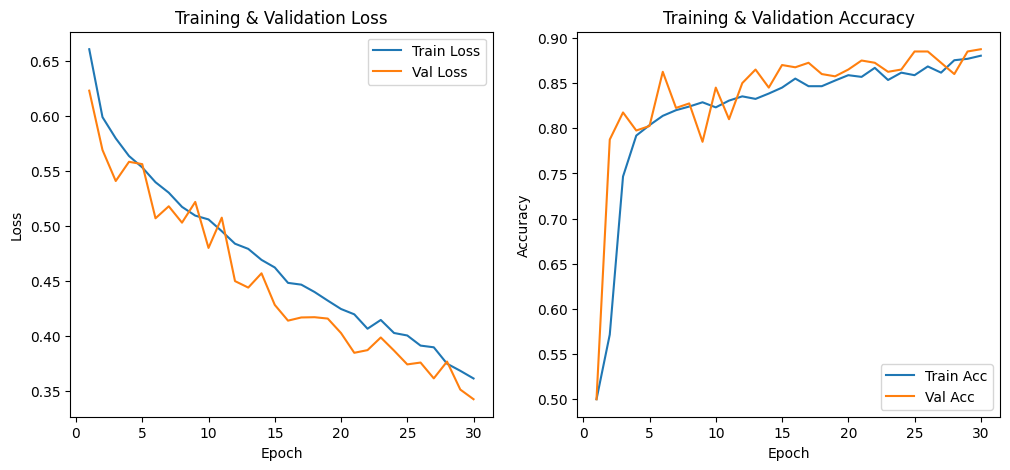

In [ ]:
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# ------------------------------------------------------
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x, y in tqdm(loader, desc="Train", leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        _, preds = outputs.max(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return running_loss/total, correct/total

@torch.no_grad()
def evaluate(model, loader, criterion, device, split="Val"):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = [], []
    for x, y in tqdm(loader, desc=split, leave=False):
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        loss = criterion(outputs, y)
        running_loss += loss.item() * x.size(0)
        _, preds = outputs.max(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
    return running_loss/total, correct/total, y_true, y_pred

best_val_loss = float("inf")
patience = 5
counter = 0
EPOCHS = 30

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS+1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion, device, split="Val")
    scheduler.step(val_loss)

    print(f"Train: loss={tr_loss:.4f}, acc={tr_acc:.4f}")
    print(f"Val:   loss={val_loss:.4f}, acc={val_acc:.4f}")

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_hybrid_model.pth")
        print("Saved best model")
    else:
        counter += 1
        print(f" EarlyStopping counter: {counter}/{patience}")
        if counter >= patience:
            print(" Early stopping triggered!")
            break

# ------------------------------------------------------
# Final test
model.load_state_dict(torch.load("best_hybrid_model.pth"))
test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader, criterion, device, split="Test")
print(f"\n=== Test Results ===")
print(f"Loss={test_loss:.4f}, Acc={test_acc:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Healthy","Malignant"]))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

# ------------------------------------------------------
# Confusion Matrix Plot
cm = confusion_matrix(y_true, y_pred)
classes = ["Healthy", "Malignant"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Plot Training Curves (Loss & Accuracy)
epochs_range = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs_range, history["train_loss"], label="Train Loss")
plt.plot(epochs_range, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs_range, history["train_acc"], label="Train Acc")
plt.plot(epochs_range, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()


Saving ISIC_0011733.jpg to ISIC_0011733.jpg


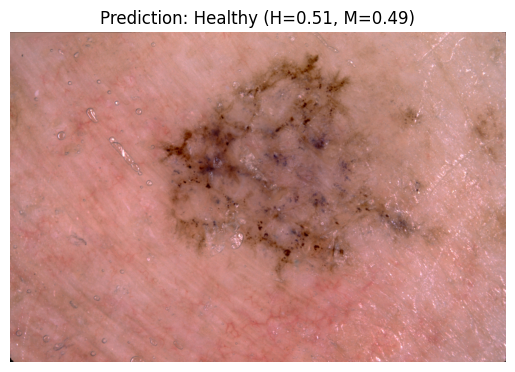

In [ ]:
from google.colab import files
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

image_size = 32
mean, std = [0.5, 0.5, 0.5], [0.5, 0.254, 0.5]
tf_eval = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# 4) معالجة الصورة
img = Image.open(img_path).convert("RGB")
x = tf_eval(img).unsqueeze(0).to(device)

# 5) تحميل أفضل موديل
model.load_state_dict(torch.load("best_hybrid_model.pth", map_location=device))
model = model.to(device)
model.eval()

with torch.no_grad():
    outputs = model(x)
    probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]
    pred = probs.argmax()

classes = ["Healthy", "Malignant"]
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {classes[pred]} (H={probs[0]:.2f}, M={probs[1]:.2f})")
plt.show()


In [1]:
pip install pennylane


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 98.0 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Saving 216.jpg to 216.jpg


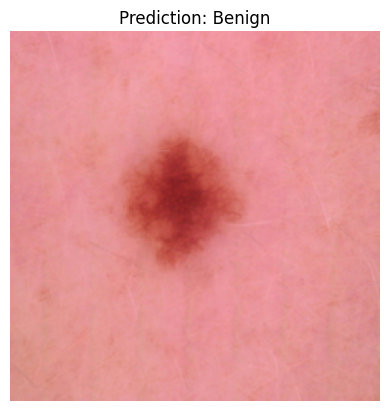

In [2]:
#This code was built by muhannad alkwiefati

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import torch.nn.functional as F

class HybridSkinCancerNet(nn.Module):
    def __init__(self, num_classes=2):
        super(HybridSkinCancerNet, self).__init__()
        # CNN part
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # ResNet feature extractor
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.fc = nn.Identity()
        # Fusion + classifier
        self.fc = nn.Sequential(
            nn.Linear(64*8*8 + 512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        cnn_feat = self.cnn(x)
        cnn_feat = cnn_feat.view(cnn_feat.size(0), -1)
        resnet_feat = self.resnet(x)
        fused = torch.cat((cnn_feat, resnet_feat), dim=1)
        out = self.fc(fused)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridSkinCancerNet(num_classes=2).to(device)
model.load_state_dict(torch.load("best_hybrid_model.pth", map_location=device), strict=False)
model.eval()

class_names = ["Benign", "Malignant"]

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),

])

uploaded = files.upload()

for filename in uploaded.keys():
    img = Image.open(filename).convert("RGB")
    inp = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(inp)
        pred_idx = torch.argmax(output, dim=1).item()
        pred_class = class_names[pred_idx]

    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis("off")
    plt.show()
